In [ ]:
import os
import urllib.request
import zipfile
from torchvision import datasets, transforms
from torch.utils.data import DataLoader



In [ ]:
url = 'http://cs231n.stanford.edu/tiny-imagenet-200.zip'
data_dir = './data'
tiny_img_zip = os.path.join(data_dir, 'tiny-imagenet-200.zip')
tiny_img_dir = os.path.join(data_dir, 'tiny-imagenet-200')

In [ ]:
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

if not os.path.exists(tiny_img_zip):
    print('Downloading Tiny ImageNet dataset...')
    urllib.request.urlretrieve(url, tiny_img_zip)


In [ ]:
if not os.path.exists(tiny_img_dir):
    print('Unzipping the dataset...')
    with zipfile.ZipFile(tiny_img_zip, 'r') as zip_ref:
        zip_ref.extractall(data_dir)


Unzipping the dataset...


In [ ]:
val_dir = os.path.join(tiny_img_dir, 'val')
val_img_dir = os.path.join(val_dir, 'images')
val_annotations_file = os.path.join(val_dir, 'val_annotations.txt')

In [ ]:
with open(val_annotations_file, 'r') as f:
    val_annotations = f.readlines()

In [ ]:
import shutil
for line in val_annotations:
    parts = line.strip().split('\t')
    img_file = parts[0]
    class_dir = parts[1]
    class_dir_path = os.path.join(val_img_dir, class_dir)
    if not os.path.exists(class_dir_path):
        os.makedirs(class_dir_path)
    shutil.move(os.path.join(val_img_dir, img_file), os.path.join(class_dir_path, img_file))

In [ ]:
transform_train = transforms.Compose([
    transforms.Resize(256, interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.CenterCrop((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

transform_val = transforms.Compose([
    transforms.Resize(256, interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [ ]:
train_dir = os.path.join(tiny_img_dir, 'train')
val_img_dir_restructured = val_img_dir

train_dataset = datasets.ImageFolder(train_dir, transform=transform_train)
val_dataset = datasets.ImageFolder(val_img_dir_restructured, transform=transform_val)

In [ ]:
class_ids = train_dataset.classes
limited_class_ids = class_ids[:10]

In [ ]:
words_file_path = './data/tiny-imagenet-200/words.txt'

id_to_classname = {}
with open(words_file_path, 'r') as f:
    for line in f:
        parts = line.strip().split('\t')
        class_id = parts[0]
        class_name = parts[1]
        id_to_classname[class_id] = class_name

class_names = [id_to_classname[class_id] for class_id in limited_class_ids]

In [ ]:
print(len(class_names))

10


In [ ]:
import torch
def filter_by_class(dataset, class_ids):
    mask = [i for i, (path, label) in enumerate(dataset.samples) if dataset.classes[label] in class_ids]
    subset = torch.utils.data.Subset(dataset, mask)
    return subset

train_dataset_filtered = filter_by_class(train_dataset, limited_class_ids)
val_dataset_filtered = filter_by_class(val_dataset, limited_class_ids)

In [ ]:

import matplotlib.pyplot as plt

goldfish, Carassius auratus


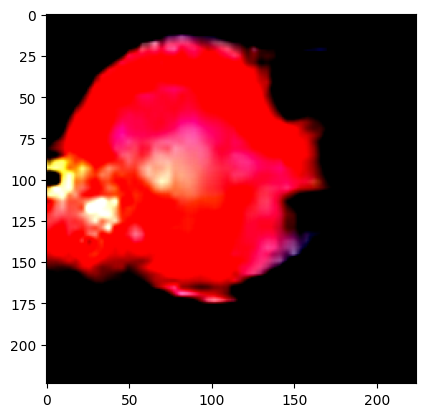

In [ ]:
plt.imshow(train_dataset[10][0].permute(1,2,0))
print(class_names[train_dataset[10][1]])

In [ ]:
from torch.utils.data import random_split

In [ ]:
calib_size = int(0.02 * len(train_dataset_filtered))
remaining_size = len(train_dataset_filtered) - calib_size

calib_set, train_set = random_split(train_dataset_filtered, [calib_size, remaining_size])

In [ ]:
print(len(train_set))

4900


In [ ]:
print(len(calib_set))

100


In [ ]:
train_loader = DataLoader(train_set, shuffle=True, batch_size=16, pin_memory=True)
calib_loader = DataLoader(calib_set, shuffle=True, batch_size=16,  pin_memory=True)
val_loader = DataLoader(val_dataset_filtered, shuffle=True, batch_size=16, pin_memory=True)

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
import torchvision
from torchvision import models
from torch import nn

In [ ]:
model = torchvision.models.resnet50(weights = models.ResNet50_Weights.IMAGENET1K_V2).to(device)
model.fc = nn.Linear(in_features=2048, out_features=10)

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model.parameters(), lr=0.00001)
def accuracy_function(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)


In [ ]:
from tqdm.auto import tqdm
def train(model, train_loader, loss_fn, optimizer, accuracy_function):
    model.train()
    model.to(device)
    running_loss, running_acc = 0.0, 0.0
    for inputs, labels in tqdm(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        running_loss += loss.item()
        running_acc += accuracy_function(labels, torch.argmax(outputs, dim=1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return running_loss/len(train_loader), running_acc/len(train_loader)

def validate(model, val_loader, loss_fn, accuracy_function):
  model.eval()
  val_loss, val_acc = 0.0, 0.0
  model.to(device)
  with torch.inference_mode():
    for inputs, labels in tqdm(val_loader):
      inputs, labels = inputs.to(device), labels.to(device)
      outputs = model(inputs)
      val_loss += loss_fn(outputs, labels)
      val_acc += accuracy_function(labels, torch.argmax(outputs, dim=1))
  return val_loss/len(val_loader), val_acc/len(val_loader)



In [ ]:
num_epochs = 10
for epoch in range(num_epochs):
    train_loss, train_acc = train(model, train_loader, loss_fn, optimizer, accuracy_function)
    val_loss, val_acc = validate(model, val_loader, loss_fn, accuracy_function)
    print(f'epoch: {epoch+1} | Training Loss: {train_loss:.4f} | Training Accuracy: {train_acc:.4f}% | Val Loss: {val_loss:.4f} | Val Accuracy: {val_acc:.4f}%')

  0%|          | 0/307 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

epoch: 1 | Training Loss: 0.0436 | Training Accuracy: 98.6971% | Val Loss: 0.6744 | Val Accuracy: 82.6172%


  0%|          | 0/307 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

epoch: 2 | Training Loss: 0.0247 | Training Accuracy: 99.3689% | Val Loss: 0.7313 | Val Accuracy: 81.8359%


  0%|          | 0/307 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

epoch: 3 | Training Loss: 0.0186 | Training Accuracy: 99.5928% | Val Loss: 0.6864 | Val Accuracy: 82.6172%


  0%|          | 0/307 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

epoch: 4 | Training Loss: 0.0196 | Training Accuracy: 99.5521% | Val Loss: 0.7288 | Val Accuracy: 81.4453%


  0%|          | 0/307 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
torch.save(model.state_dict(), 'resnet50trained.pth')

In [ ]:
model.eval()
model.to(device)
conformal_scores = []

with torch.inference_mode():
  for img, label in calib_loader:
    img, label = img.to(device), label.to(device)
    outputs = model(img)
    softmax_scores = torch.softmax(outputs, dim=1)
    true_softmax = softmax_scores.gather(1, label.unsqueeze(1)).squeeze()
    conformal_scores.append(1-true_softmax)

conformal_scores = torch.cat(conformal_scores)
conformal_scores = conformal_scores.cpu().numpy()

In [ ]:
import numpy as np
n = len(calib_set)
alpha = 0.05
q_level = np.ceil((n+1)*(1-alpha)) / n
qhat = np.quantile(conformal_scores, q_level, method='higher')
qhat

0.9733008

In [ ]:
import random
#select 10 indices from the test_data
test_indices = list(range(len(val_dataset_filtered)))
selected_indices = random.sample(test_indices, 10)
new_samples = torch.utils.data.Subset(val_dataset_filtered, selected_indices)

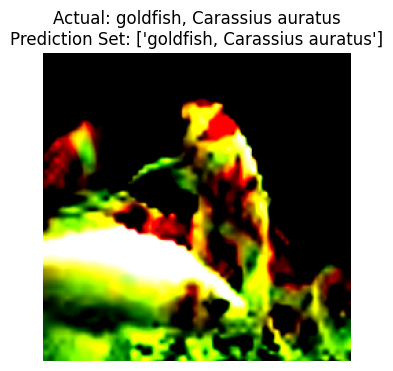

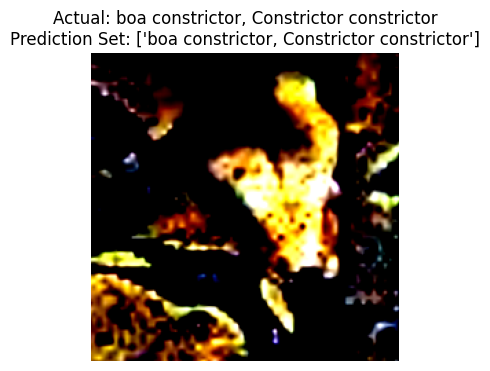

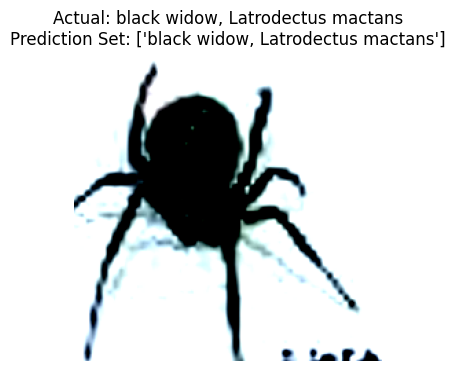

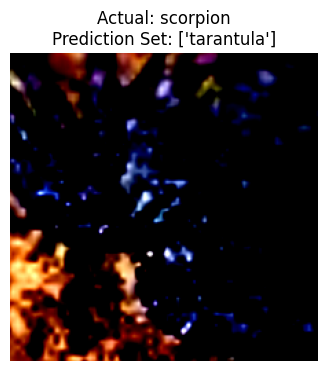

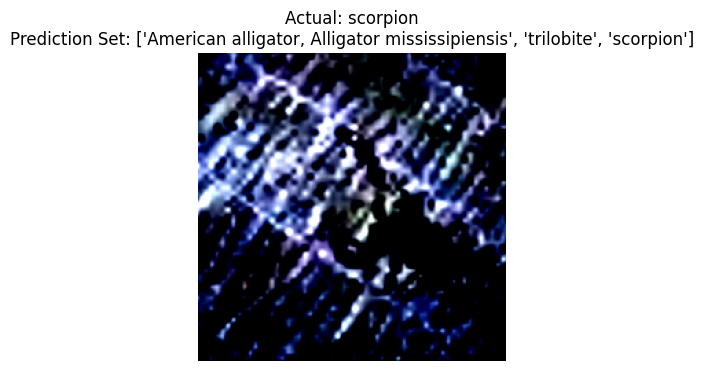

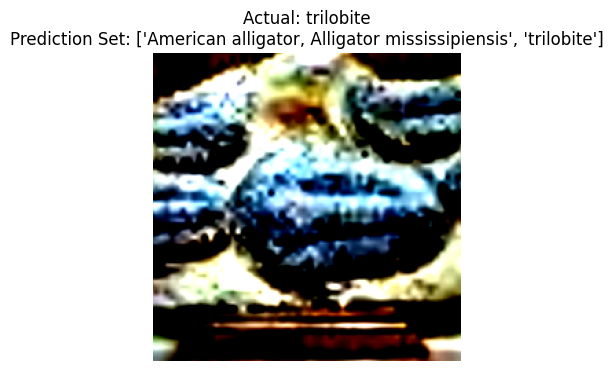

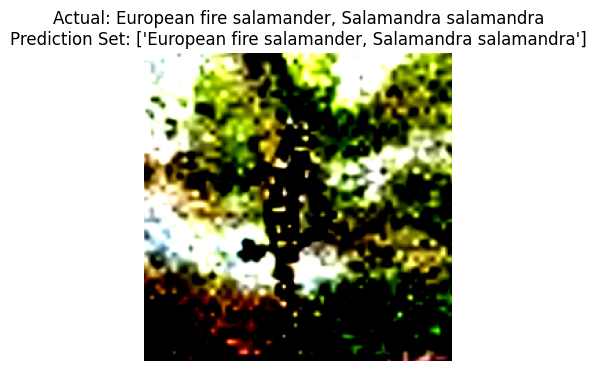

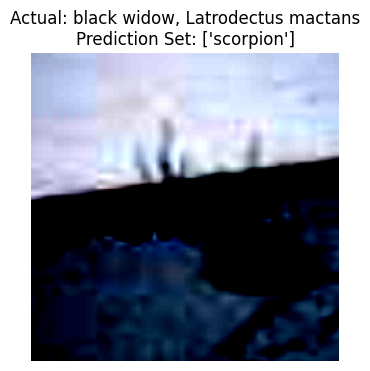

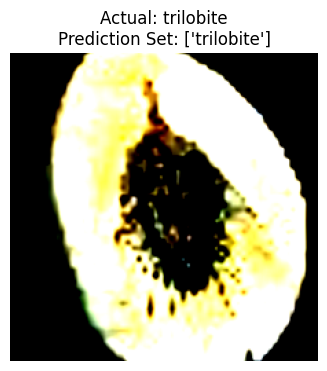

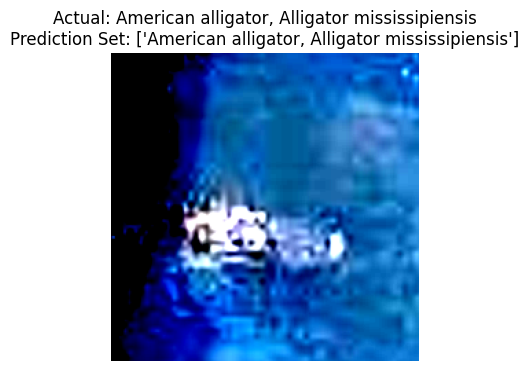

In [ ]:
import matplotlib.pyplot as plt

prediction_sets = []
model.eval()
model = model.to(device)
with torch.inference_mode():
  for i, (img, label) in enumerate(new_samples):
    img = img.to(device)
    outputs = model(img.unsqueeze(dim=0))
    softmax_probs = torch.softmax(outputs, dim=1).squeeze().cpu().numpy()
    prediction_set = np.where(softmax_probs >= (1-qhat))[0]
    prediction_set = [class_names[idx] for idx in prediction_set]

    plt.figure(figsize=(8, 4))
    plt.imshow(img.cpu().permute(1,2,0))
    plt.title(f"Actual: {class_names[label]}\nPrediction Set: {(prediction_set)}")
    plt.axis('off')
    plt.show()